In [2]:
from __future__ import print_function 
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

### Implement computation by network

In [3]:
def relu(x):
    return np.maximum(x,0)


def sort_edges(net): # must be sorted so that edge (u,v) is after all edges required to compute u 
    nodes_sorted = nx.topological_sort(net) # if (u,v) is an edge, then u will be earlier than v
    edges_sorted = [(node0, node1) for node1 in nodes_sorted for node0 in net.predecessors(node1)]
    return edges_sorted


def compute(x,  # network input 
            net, # a ReLU network
            printEdges=False # debug
           ):
    for node in net.nodes:
        if node == 'in':
            net.nodes[node]['x'] = x
        else:
            net.nodes[node]['x'] = net.nodes[node]['h'] if net.nodes[node]['h'] else 0.0  # node output initialized by bias
    
    for edge in sort_edges(net):
        if printEdges:
            print (edge)
        node0 = net.nodes[edge[0]]
        node1 = net.nodes[edge[1]]
        
        if not edge[0] == 'in':
            node0['x'] = relu(node0['x']) # apply ReLU at hidden neurons 
        
        node1['x'] += net.edges[edge]['w']*node0['x']
    
    return net.nodes['final']['x']#, net.nodes['3final']['x'], net.nodes['5final']['x'], net.nodes['9final']['x']

### The sawtooth

$$g_m = \underbrace{g \circ g \circ ...\circ g}_m,$$
where the single tooth function
$$g(x)=\begin{cases}2x,&x<\tfrac{1}{2},\\1-2x,&x>\tfrac{1}{2}\end{cases} = (2x)_+-(4x-2)_+, \quad (0\le x\le 1)$$

In [4]:
def getSawtoothNet(m # number of iterations
                  ):
    net = nx.DiGraph()    
    net.add_node('in')
    net.add_node('final')
    for n in range(m):
        net.add_node((n,0))
        net.add_node((n,1))
        if n == 0:
            net.add_edge('in', (0,0))
            net.add_edge('in', (0,1))
        else:
            net.add_edge((n-1,0), (n,0))
            net.add_edge((n-1,0), (n,1))  
            net.add_edge((n-1,1), (n,0))
            net.add_edge((n-1,1), (n,1)) 
        if n == m-1:
            net.add_edge((m-1,0), 'final')
            net.add_edge((m-1,1), 'final')
    
    # weights
    # first layer
    net.edges['in', (0,0)]['w'] = 2.
    net.nodes[(0,0)]['h'] = 0.
    
    net.edges['in', (0,1)]['w'] = 4.
    net.nodes[(0,1)]['h'] = -2.
    
    # intermediate layers
    for n in range(1, m):
        net.edges[(n-1,0), (n,0)]['w'] = 2.
        net.edges[(n-1,1), (n,0)]['w'] = -2.
        net.nodes[(n,0)]['h'] = 0.

        net.edges[(n-1,0), (n,1)]['w'] = 4.
        net.edges[(n-1,1), (n,1)]['w'] = -4.
        net.nodes[(n,1)]['h'] = -2.
    
    # last layer
    net.edges[(m-1,0), 'final']['w'] = 1.
    net.edges[(m-1,1), 'final']['w'] = -1.
    net.nodes['in']['h'] = 0.0
    net.nodes['final']['h'] = 0.0   
    
    return net

In [5]:
def draw(net, **qwargs):
    pos = nx.spring_layout(net)
    nodes_sorted = list(nx.topological_sort(net))
    
    yposA = np.zeros(len(net.nodes), 'int') # occupation numbers in x position 0, 1, ...
    yposA[0] = 1 
    
    for node in nodes_sorted:
        if list(net.predecessors(node)):
            k = np.max([pos[node0][0] for node0 in net.predecessors(node)])
            xpos = k+1
        else:
            xpos = 0
        
        pos[node] = (xpos, yposA[xpos]+0.4*np.random.rand())
        yposA[xpos] += 1
    
    nx.draw(net, pos, **qwargs)

    draw(net, with_labels=True, node_color='red')

### The ReLU network for approximate squaring

$$x^2\approx x-\sum_{n=1}^m\frac{g_n(x)}{2^{2n}}$$

In [11]:
def getSquaringNet(m, label='0'): # assume 0 <= x <= 1    
    net = getSawtoothNet(m)
    
    for n in range(m-1):
        net.add_edge((n,0), 'final')
        net.add_edge((n,1), 'final')
    net.add_edge('in', 'final')

    for n in range(m):
        net.edges[(n,0), 'final']['w'] = -0.5**(2*(n+1)) 
        net.edges[(n,1), 'final']['w'] = 0.5**(2*(n+1)) 
    net.edges['in', 'final']['w'] = 1.
        
    return net

We will approximate $\sin (x)$ by expanding it into Taylor series and approximating each term. Since we can approximate $x^2$ on $[0, 1]$ we will consider $\sin(\pi t), t \in [0, 1]$.
$$ \sin (\pi t) = \sum_{k = 0}^\infty (-1)^ k \frac{(\pi t)^{2k + 1}}{(2k + 1)!} = \pi t - \frac{\pi^3 t^3}{3!} + \frac{\pi^5 t^5}{5!} + o(t^6)$$ 
If we know how to approximate $x^2$ we can approximate the product of 2 numbers:
$$xy = \frac{1}{4}( (x + y)^2 - (x - y)^2)$$
\begin{gather}
x^3 = \frac{1}{4}( (x + x^2)^2 - (x - x^2)^2) = \left(\frac{x + x^2}{2}\right)^2 - \left( \frac{x - x^2}{2} \right)^2 \\
x^5 = \left(\frac{x^3 + x^2}{2}\right)^2 - \left( \frac{x^3 - x^2}{2} \right)^2 \\
x^7 = \left(\frac{x^5 + x^2}{2}\right)^2 - \left( \frac{x^5 - x^2}{2} \right)^2 \\
x^7 = \left(\frac{x^5 + x^2}{2}\right)^2 - \left( \frac{x^5 - x^2}{2} \right)^2 \\
x^9 = \left(\frac{x^7 + x^2}{2}\right)^2 - \left( \frac{x^7 - x^2}{2} \right)^2 \\
x^{11} = \left(\frac{x^9 + x^2}{2}\right)^2 - \left( \frac{x^9 - x^2}{2} \right)^2 \\
x^{13} = \left(\frac{x^{11} + x^2}{2}\right)^2 - \left( \frac{x^{11} - x^2}{2} \right)^2
\end{gather}

In [7]:
def LinNet(): #simple net that returns its input without changes
    net = nx.DiGraph()    

    net.add_node('in')
    net.add_node('final')
    net.nodes['in']['h'] = 0.0
    net.nodes['final']['h'] = 0.0

    net.add_edge('in', 'final')
    net.edges['in', 'final']['w'] = 1
    
    return net


def getCubeNet(m): #approximates x^3 (had to do it separately since x > x^2 on [0, 1])  


    net = nx.union(LinNet(), getSquaringNet(m), rename=('0', '2'))

    net.add_edge('0in', '2in')
    net.edges['0in', '2in']['w'] = 1


    net.add_node('minus')

    net.add_edge('0final', 'minus')
    net.add_edge('2final', 'minus')

    net.nodes['minus']['h'] = 0.0
    net.edges['0final', 'minus']['w'] = 0.5
    net.edges['2final', 'minus']['w'] = -0.5

    
    net.add_node('plus')

    net.add_edge('0final', 'plus')
    net.add_edge('2final', 'plus')

    net.nodes['plus']['h'] = 0.0
    net.edges['0final', 'plus']['w'] = 0.5
    net.edges['2final', 'plus']['w'] = 0.5


    net = nx.union(net, getSquaringNet(m), rename=('', 'p'))
    net = nx.union(net, getSquaringNet(m), rename=('', 'm'))


    net.add_edge('minus', 'min')
    net.edges['minus', 'min']['w'] = 1

    net.add_edge('plus', 'pin')
    net.edges['plus', 'pin']['w'] = 1

    
    net.add_node('final')

    net.add_edge('pfinal', 'final')
    net.add_edge('mfinal', 'final')

    net.nodes['final']['h'] = 0.0
    net.edges['pfinal', 'final']['w'] = 1
    net.edges['mfinal', 'final']['w'] = -1



    mapping = {'0in':'in'}
    net = nx.relabel_nodes(net, mapping)
   
    return net

In [13]:
def NextPower(prev_net, m): #if prev_net approximates x^n than NextPower(prev_net, m) approximates x^{n + 2}

    net = nx.union(prev_net, getSquaringNet(m), rename=('0', '2'))

    net.add_edge('0in', '2in')
    net.edges['0in', '2in']['w'] = 1


    net.add_node('minus')

    net.add_edge('0final', 'minus')
    net.add_edge('2final', 'minus')

    net.nodes['minus']['h'] = 0.0
    net.edges['0final', 'minus']['w'] = -0.5
    net.edges['2final', 'minus']['w'] = 0.5

    
    net.add_node('plus')

    net.add_edge('0final', 'plus')
    net.add_edge('2final', 'plus')

    net.nodes['plus']['h'] = 0.0
    net.edges['0final', 'plus']['w'] = 0.5
    net.edges['2final', 'plus']['w'] = 0.5


    net = nx.union(net, getSquaringNet(m), rename=('', 'p'))
    net = nx.union(net, getSquaringNet(m), rename=('', 'm'))


    net.add_edge('minus', 'min')
    net.edges['minus', 'min']['w'] = 1

    net.add_edge('plus', 'pin')
    net.edges['plus', 'pin']['w'] = 1

    
    net.add_node('final')

    net.add_edge('pfinal', 'final')
    net.add_edge('mfinal', 'final')

    net.nodes['final']['h'] = 0.0
    net.edges['pfinal', 'final']['w'] = 1
    net.edges['mfinal', 'final']['w'] = -1


    mapping = {'0in':'in'}
    net = nx.relabel_nodes(net, mapping)
    
        
    return net

In [14]:
def PowerNet(power, m): #return net that approximates x^power
  net = getCubeNet(m)
  if power == 1:
    return LinNet()
  else:
    for _ in range((power - 3) // 2):
      net = NextPower(net, m)

    return net

In [15]:
mem = {}
mem[0] = 1
mem[1] = 1
def fact(n):
  if n not in mem:
    mem[n] = n * fact(n - 1)
  return mem[n]


def sin_coef(k): #sin(pi t) taylor series coefficients
  return (np.pi ** k) * ((-1) ** ((k - 1)//2)) / fact(k)

In [16]:
def SinNet(p, m): #approximate sin(x) for 0 <= x <= pi. p - degree of taylor series expansion, m - depth
  net = PowerNet(p, m)
  mapping = {'final':'output'}
  net = nx.relabel_nodes(net, mapping)

  net.add_node('output')
  net.add_edge('output', 'final')

  k = 1
  for i in range((p - 1) // 2, 0, -1): #node '000final' is the output the approximates some power of x. max num of 0 in name is (p - 1) // 2
    net.add_edge('0' * i + 'final', 'final')
    net.edges['0' * i + 'final', 'final']['w'] = sin_coef(k)
    k += 2


  net.nodes['final']['h'] = 0.0
  net.edges['output', 'final']['w'] = sin_coef(k)


  for neigh in net['in']:
    net['in'][neigh]['w'] /= np.pi


  return net

def SinNet1(p, m): #can also approximate -pi <= x <= 0
  net = nx.union(SinNet(p, m), SinNet(p, m), rename=('pos', 'neg'))

  net.add_node('in')
  net.add_node('final') 

  net.nodes['in']['h'] = 0.0
  net.nodes['final']['h'] = 0.0

  net.add_edge('in', 'posin')
  net.add_edge('in', 'negin')

  net.add_edge('posfinal', 'final')
  net.add_edge('negfinal', 'final')

  net.edges['in', 'posin']['w'] = 1
  net.edges['in', 'negin']['w'] = -1
  net.edges['posfinal', 'final']['w'] = 1
  net.edges['negfinal', 'final']['w'] = -1
  
  return net

  

In [65]:
def SinNet(p, m):
  net = PowerNet(p, m) #max num of 0 is (p - 1) // 2
  mapping = {'final':'output'}
  net = nx.relabel_nodes(net, mapping)

  net.add_node('output')
  net.add_edge('output', 'final')

  k = 1
  for i in range((p - 1) // 2, 0, -1):
    net.add_edge('0' * i + 'final', 'final')
    net.edges['0' * i + 'final', 'final']['w'] = (np.pi ** k) * ((-1) ** ((k - 1)//2)) / fact(k)
    k += 2


  net.nodes['final']['h'] = 0.0
  net.edges['output', 'final']['w'] = (np.pi ** k) * ((-1) ** ((k - 1)//2)) / fact(k)


  for neigh in net['in']:
    net['in'][neigh]['w'] /= np.pi


  return net

Network size and accuracy:
depth 19 : 8384 edges and 2960 nodes; max error: 8.211912107345537004e-12
depth 20 : 8816 edges and 3104 nodes; max error: 2.0468893507236129992e-12
depth 21 : 9248 edges and 3248 nodes; max error: 5.0869893150271017213e-13
depth 22 : 9680 edges and 3392 nodes; max error: 1.2659209618071098902e-13
depth 23 : 10112 edges and 3536 nodes; max error: 3.176186527328872522e-14


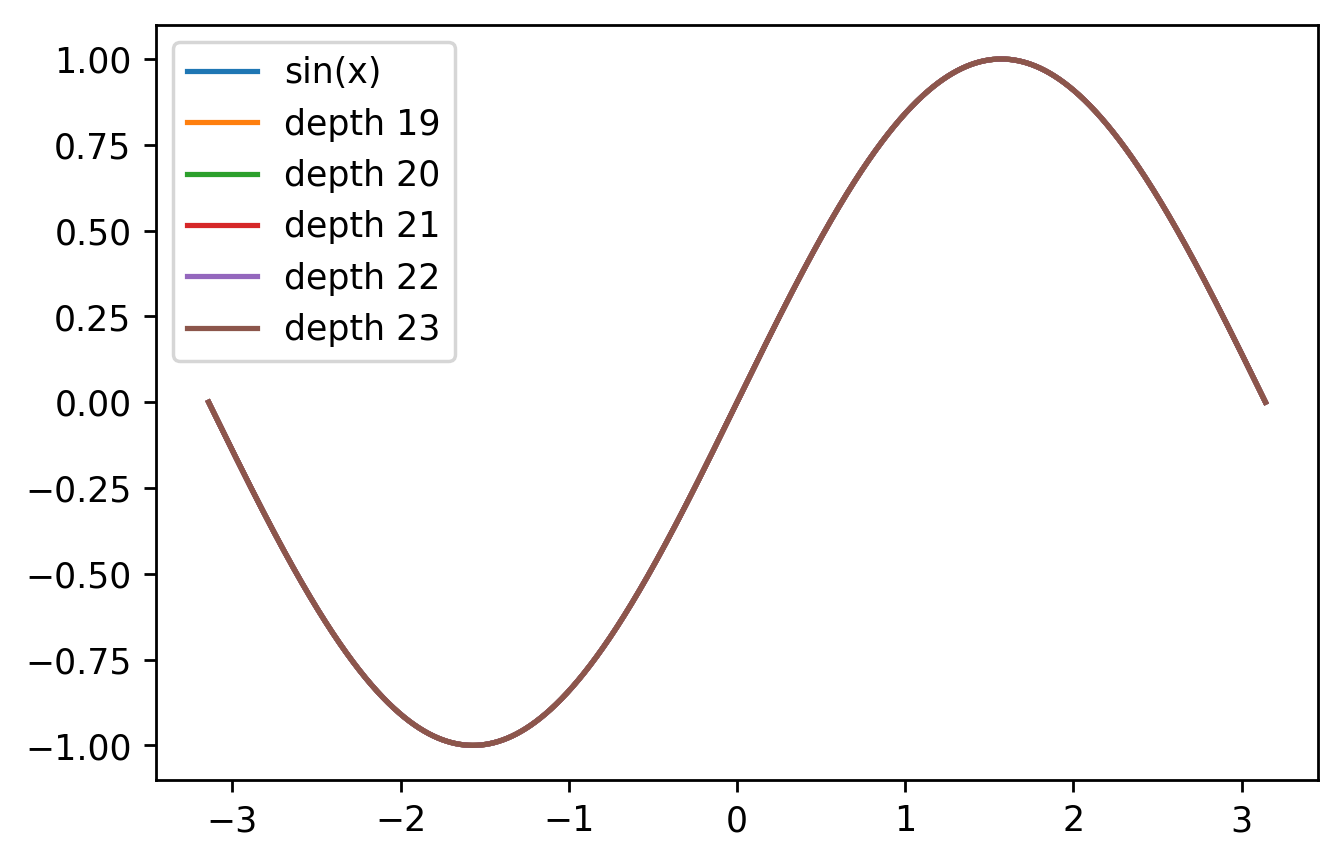

In [17]:
np.set_printoptions(precision=13)
x = np.linspace(-np.pi,np.pi,10**5)
y = np.sin(x, dtype=np.longdouble)
plt.figure(dpi=250)
plt.plot(x, y, label='sin(x)')
print ('Network size and accuracy:')

for m in range(19, 24 ,1):
    net = SinNet1(26, m)
    y_pred = compute(x, net)
    print ('depth', m, ':', len(net.edges), 'edges and',len(net.nodes),'nodes; max error:', (np.max(np.abs(y_pred-y))))
    plt.plot(x, y_pred, label='depth '+str(m))

plt.legend()
plt.show()

SinNet1(26, 22) approximates $sin(x)$ on $[-\pi, \pi]$ with uniform error $\approx 1.3 \cdot 10^{-13}$. It uses 9680 weights. 